In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # noqa
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # noqa

In [2]:
import yaml
import shutil
import random
import warnings
from pathlib import Path

import cv2
import pandas as pd
import numpy as np
import torch
import xml.etree.ElementTree as et 
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.style as style
style.use('seaborn-poster')

warnings.filterwarnings("ignore")

DATA_DIR = Path('/mnt/data/zp/zenodo/dataset')

# Load data

dataseet https://zenodo.org/record/2654485#.YdbekmgzZPZ

Parce all xmls and transform data to table 

In [3]:
def load_annotation(path: Path) -> pd.DataFrame:
    df = list()
    dir_idx = path.name[-5]
    img_dir = DATA_DIR / f'sequence_{dir_idx}'
    
    xtree = et.parse(path)
    xroot = xtree.getroot()
    
    images = xroot.find('images')
    for img_node in images:
        img_file = img_node.attrib.get('file')
        for box_node in img_node:
            top = box_node.attrib.get('top')
            left = box_node.attrib.get('left')
            width = box_node.attrib.get('width')
            height = box_node.attrib.get('height')
            for label_node in box_node:
                label = label_node.text
                df.append(
                    {
                        'img_file': img_file,
                        'img_path': str(img_dir / img_file),
                        'top': int(top),
                        'left': int(left),
                        'width': int(width),
                        'height': int(height),
                        'label': label
                    }
                )
    
    return pd.DataFrame(df)

In [4]:
data = pd.DataFrame()
for i in range(1, 7):
    df = load_annotation(DATA_DIR / f'annotation/annotation_s{i}.xml')
    data = data.append(df, ignore_index=True)

data.shape

(4595, 7)

In [5]:
data.head()

,img_file,img_path,top,left,width,height,label
0,frame_s1_1.jpg,/mnt/data/zp/zenodo/dataset/sequence_1/frame_s...,244,500,192,99,exit
1,frame_s1_1.jpg,/mnt/data/zp/zenodo/dataset/sequence_1/frame_s...,358,742,218,105,exit
2,frame_s1_10.jpg,/mnt/data/zp/zenodo/dataset/sequence_1/frame_s...,97,651,79,81,fireextinguisher
3,frame_s1_10.jpg,/mnt/data/zp/zenodo/dataset/sequence_1/frame_s...,354,667,109,281,fireextinguisher
4,frame_s1_100.jpg,/mnt/data/zp/zenodo/dataset/sequence_1/frame_s...,159,460,172,169,clock


Make mapping from class name to class id

In [6]:
label_id_map = {label: i for i, label in enumerate(data['label'].unique())}
label_id_map_back = {v:k for k, v in label_id_map.items()}

data['label_id'] = data['label'].apply(lambda x: label_id_map[x])

Class distribution

<AxesSubplot:>

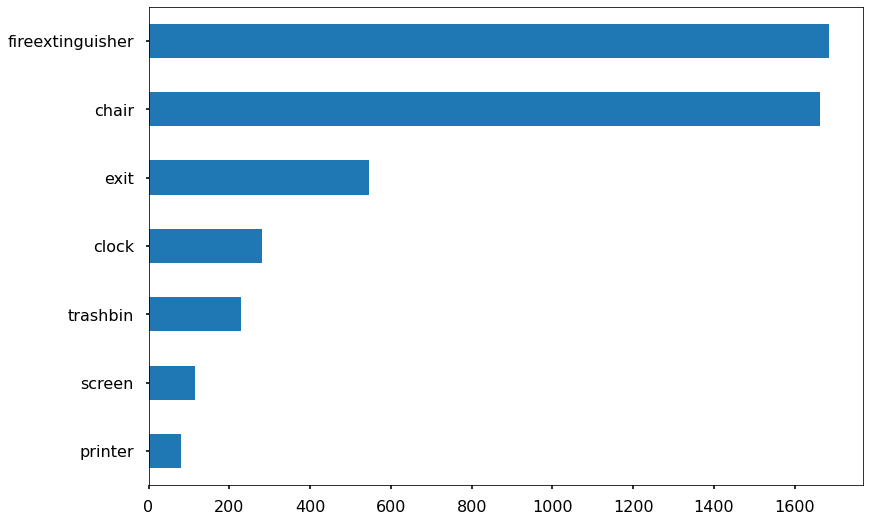

In [7]:
data['label'].value_counts().sort_values().plot(kind='barh')

Let's look at the distribution of objects in the pictures

<AxesSubplot:>

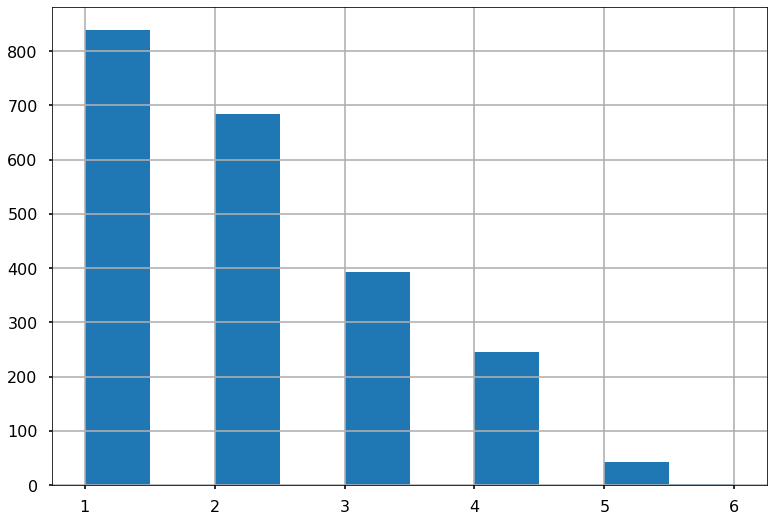

In [8]:
data['img_file'].value_counts().hist()

Let's randomly select pictures and look at the labeled object on them

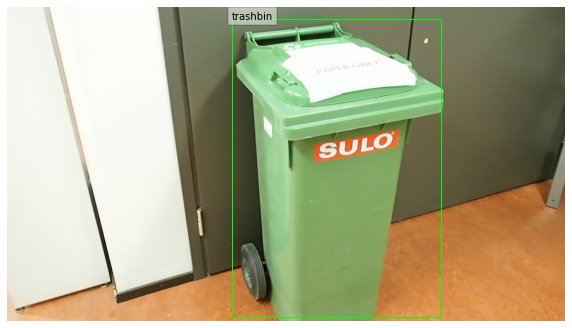

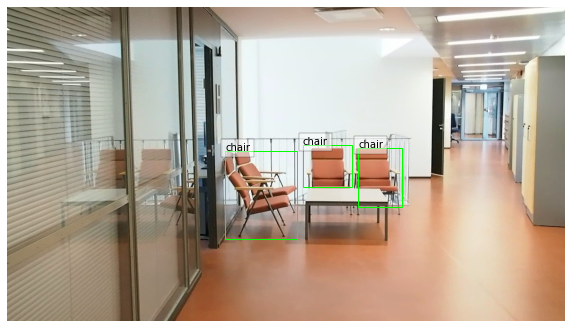

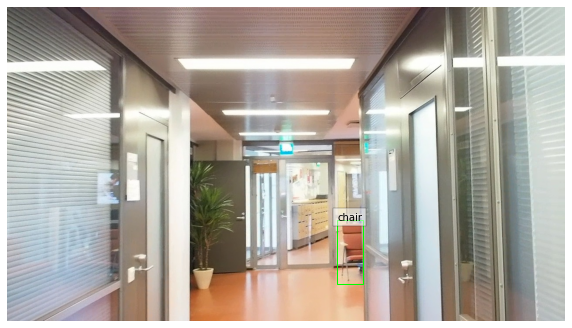

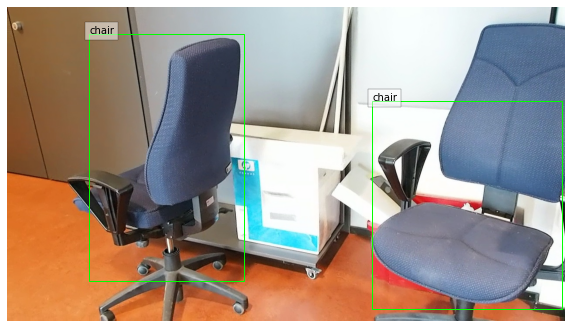

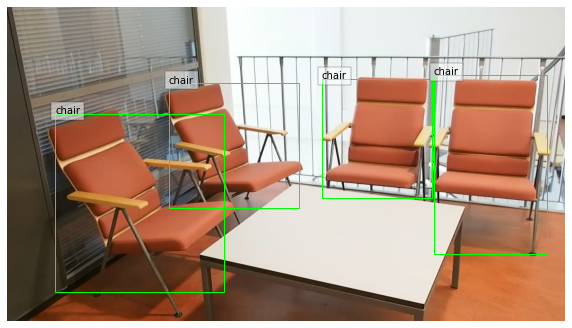

In [9]:

for _ in range(5):
    i = random.randint(0, len(data))
    img_path = data.iloc[i]['img_path']
    img = plt.imread(img_path)
    cond = data['img_file'] == data.iloc[i]['img_file']

    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(img)
    ax = plt.gca()

    img_w, img_h = img.shape[:2]
    for row in data[cond].itertuples():
        ttext = "{}".format(row.label)

        tx1, ty1, tw, th = row.left, row.top, row.width, row.height 

        patch = plt.Rectangle(
            [tx1, ty1], tw, th, fill=False, edgecolor=[0, 1, 0], linewidth=1
        )
        ax.add_patch(patch)
        ax.text(
            tx1,
            ty1,
            ttext,
            bbox={"facecolor": [1, 1, 1], "alpha": 0.5},
            clip_box=ax.clipbox,
            clip_on=True,
        )

    plt.show()
    

# Form dataset

Split dataset on train and valid part

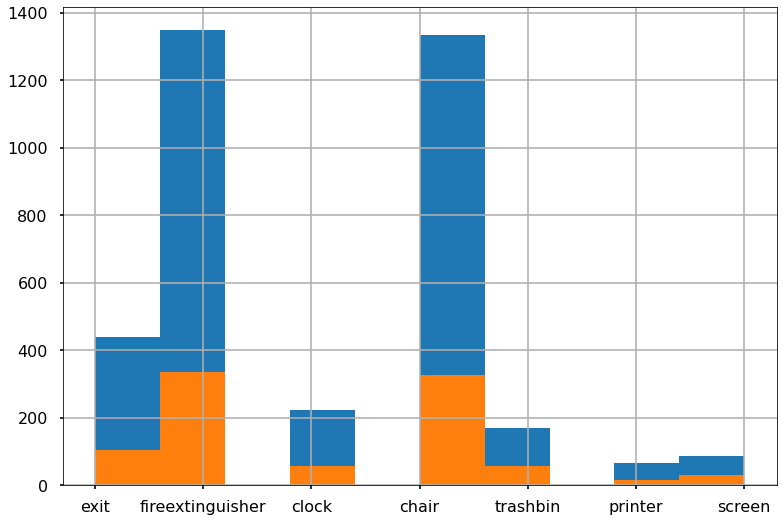

In [10]:
unique_imgs = data['img_file'].unique()
train_imgs, valid_imgs = train_test_split(unique_imgs, test_size=0.2, random_state=42)

cond = data['img_file'].isin(train_imgs)
train_data = data[cond]
valid_data = data[~cond]

train_data['label'].hist()
valid_data['label'].hist()

plt.show()

Looks balanced

#### Form train and valid datasets for Yolo

# From Yolo dataset

In [11]:
def make_yolo_dataset(data: pd.DataFrame, output_dir: Path):
    if output_dir.exists():
        shutil.rmtree(output_dir)
    
    (output_dir / 'images').mkdir(parents=True)
    (output_dir / 'labels').mkdir(parents=True)

    for img_file, group in data.groupby('img_file'):
        img = plt.imread(group.iloc[0].img_path)
        img_w, img_h = img.shape[:2]
        shutil.copyfile(group.iloc[0].img_path, output_dir / f'images/{img_file}')

        with (output_dir / f'labels/{img_file[:-4]}.txt').open('a') as file:
            for row in group.itertuples():
                x_center = (float(row.left) + float(row.width) / 2)  / img_h
                y_center = (float(row.top) + float(row.height) / 2) / img_w
                width = float(row.width) / img_h
                height = float(row.height) / img_w
                row_out = f'{row.label_id} {x_center} {y_center} {width} {height}\n'
                file.write(row_out)

In [12]:
YOLO_DATA_DIR = DATA_DIR / 'yolo'

make_yolo_dataset(train_data, YOLO_DATA_DIR / 'train')
make_yolo_dataset(valid_data, YOLO_DATA_DIR / 'valid')

In [13]:
 hyp_dict = {
     'path': str(YOLO_DATA_DIR),
     'train': str(YOLO_DATA_DIR / 'train/images'),
     'val': str(YOLO_DATA_DIR / 'valid/images'),
     
     'nc': len(label_id_map_back),
     'names': [label_id_map_back[i] for i in range(len(label_id_map_back))],
 }
    
    
with open('hyp.yaml', 'w') as outfile:
    yaml.dump(hyp_dict, outfile, default_flow_style=False)

# Train model

model https://github.com/ultralytics/yolov5

clon the repo neaby the notebook and named it yolov5

In [14]:
import wandb
# Init Wandb
wandb.login()
wandb.init(
    project='Object detection',
    entity='kmike',
    reinit=True,
    name='Public',
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kmike (use `wandb login --relogin` to force relogin)


In [15]:
!python yolov5/train.py --img 720 --batch 16 --epochs 5 --data hyp.yaml --weights yolov5s.pt

wandb: Currently logged in as: kmike (use `wandb login --relogin` to force relogin)
train: weights=yolov5s.pt, cfg=, data=hyp.yaml, hyp=yolov5/data/hyps/hyp.scratch.yaml, epochs=5, batch_size=16, imgsz=720, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2022-1-13 torch 1.7.0 CUDA:0 (GeForce GTX 1080 Ti, 11178MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0

               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        442        925      0.775      0.847      0.863      0.565

5 epochs completed in 0.105 hours.
Optimizer stripped from yolov5/runs/train/exp11/weights/last.pt, 14.4MB

Validating yolov5/runs/train/exp11/weights/best.pt...
Optimizer stripped from yolov5/runs/train/exp11/weights/best.pt, 14.4MB
Fusing layers... 
Model Summary: 213 layers, 7029004 parameters, 0 gradients
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        442        925      0.775      0.848      0.864      0.565
                exit        442        105      0.774      0.981      0.961      0.633
    fireextinguisher        442        334      0.892      0.994      0.991      0.674
               clock        442         56      0.611          1       0.97       0.57
               chair        442        327      0.867      0.972      0.973      0.627
    

More details you can see here

https://wandb.ai/kmike/train?workspace=user-kmike

# Show results

In [16]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp11/weights/best.pt') 

Using cache found in /home/jupyter/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-1-13 torch 1.7.0 CUDA:0 (GeForce GTX 1080 Ti, 11178MiB)

Fusing layers... 
Model Summary: 213 layers, 7029004 parameters, 0 gradients
Adding AutoShape... 


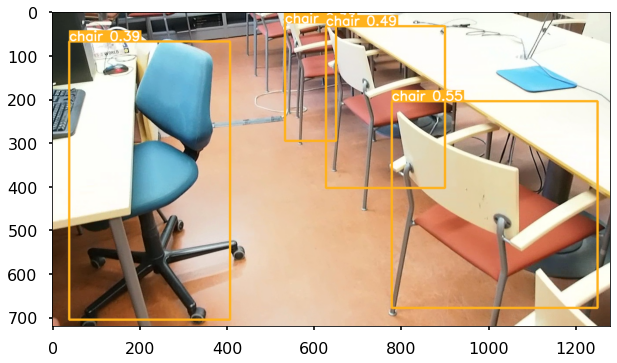

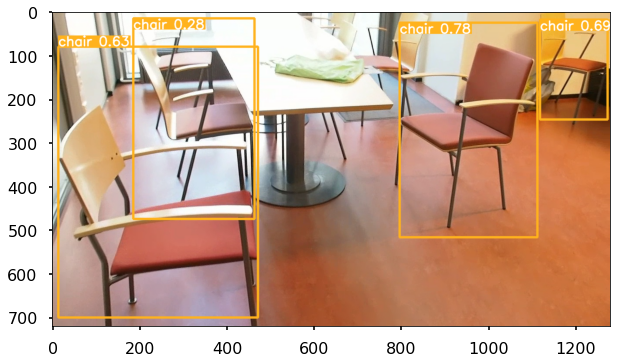

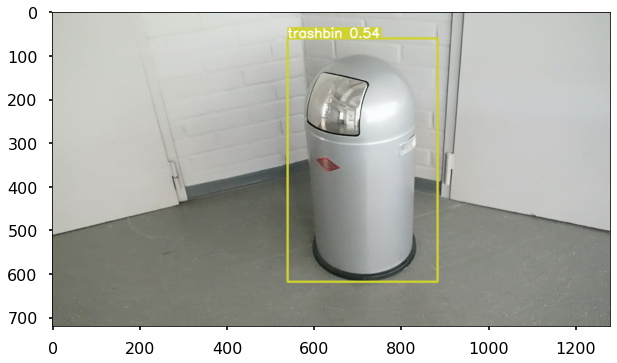

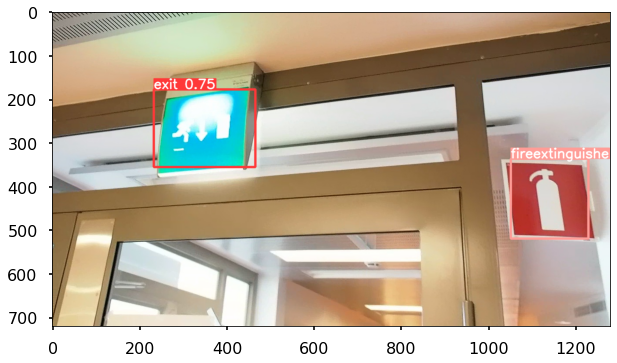

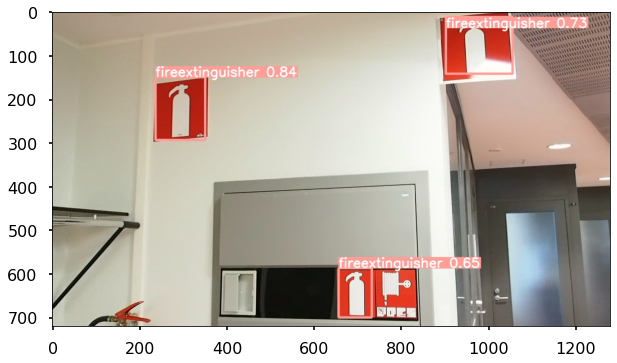

In [17]:
for _ in range(5):

    i = random.randint(0, len(valid_data))
    img_path = valid_data.iloc[i]['img_path']
    img = plt.imread(img_path)
    
    plt.figure(figsize=(10, 10))
    results = model(img)
    results.display(show=True)
    plt.imshow(img)
    
    plt.show()

### Example table predicttion

In [18]:
results.pandas().xyxy[0]

,xmin,ymin,xmax,ymax,confidence,class,name
0,237.347137,149.462036,351.750519,293.441345,0.844525,1,fireextinguisher
1,903.377136,11.318520,1056.107422,141.589417,0.731837,1,fireextinguisher
2,657.973145,587.441345,733.970947,700.317322,0.653177,1,fireextinguisher


### Validation metrics

In [19]:
!python yolov5/val.py --data hyp.yaml --weights yolov5/runs/train/exp11/weights/best.pt

val: data=hyp.yaml, weights=['yolov5/runs/train/exp11/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 2022-1-13 torch 1.7.0 CUDA:0 (GeForce GTX 1080 Ti, 11177MiB)

Fusing layers... 
Model Summary: 213 layers, 7029004 parameters, 0 gradients
val: Scanning '/mnt/data/zp/zenodo/dataset/yolo/valid/labels.cache' images and l
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        442        925      0.847      0.801      0.858      0.567
                exit        442        105      0.801       0.96      0.952      0.636
    fireextinguisher        442        334      0.921      0.991      0.989      0.661
               clock        442         56      0.764          1      0.983  

I did not set myself the task of getting excellent metrics, but this could be done using classical things such as ensembles, augmentations, etc.